# **Annotation of artefacts**

## Introduction

This chapter will show how artefacts can be identified and then annotated. The annotations will be encoded in the FIF data file. Sections or trials will not be rejected at this stage; rather, the annotations may be used later. For instance, they can be used to reject trials with eyeblinks or muscle contractions depending on their relevance for the analysis.


## Preparations

### Import the necessary modules

Below are the required Python modules


In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import array
import os.path as op
from mne_bids import (
    BIDSPath,
    read_raw_bids
)
from mne.preprocessing import annotate_muscle_zscore

### File overview

The chapter relies on the input files (embedded in the BIDS structure):
```
< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif
```

and generates the output files:

```
< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif
< BIDS_ROOT >/derivatives/Preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.csv

```

### Loading the BIDS data

Specify the parameters allowing for defining the path for the BIDS path


In [2]:
subject = '01'
session = '01'
task = 'SpAtt'
run = '01'
meg_suffix = 'meg'
hfc_suffix = 'hfc_raw'
ann_suffix = 'ann_raw'

# data_path='C:/Users/rakshita/Documents/Cerca_raw_files'
data_path = '/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif'

bids_root = op.join(data_path, "Cerca_Spatt_BIDS")
deriv_root = op.join(bids_root, "derivatives/preprocessing")

bids_path = BIDSPath(subject=subject, session=session, datatype='meg',
            task=task, run=run, suffix=hfc_suffix, 
            root=deriv_root, extension='.fif', check=False)

deriv_fname = bids_path.basename.replace(hfc_suffix, ann_suffix) # fif output filename
deriv_fname_fif = op.join(bids_path.directory, deriv_fname)

deriv_fname_csv = deriv_fname_fif.replace('.fif', '.csv') # csv output filename

print(bids_path)
print(deriv_fname_fif)
print(deriv_fname_csv)

/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif
/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif
/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.csv


Read the raw data

In [3]:
raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)

Opening raw data file /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 180) active
        HFC: l=1 m=0 (1 x 180) active
        HFC: l=1 m=1 (1 x 180) active
        HFC: l=2 m=-2 (1 x 180) active
        HFC: l=2 m=-1 (1 x 180) active
        HFC: l=2 m=0 (1 x 180) active
        HFC: l=2 m=1 (1 x 180) active
        HFC: l=2 m=2 (1 x 180) active
    Range : 0 ... 1539807 =      0.000 ...  2053.076 secs
Ready.
Reading 0 ... 1539807  =      0.000 ...  2053.076 secs...


/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_41782/1492964947.py:1: RuntimeWarning: Did not find any events.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*events.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_41782/1492964947.py:1: RuntimeWarning: Did not find any channels.tsv associated with sub-01_ses-01_task-SpAtt_run-01.

The search_str was "/Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/**/meg/sub-01_ses-01*channels.tsv"
  raw = read_raw_bids(bids_path=bids_path, extra_params={'preload':True}, verbose=True)
/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_41782/1492964947.py:1: RuntimeWarning: Did not find any m

Comment from OJ: events.tsv channels.tsv etc are not found here. I guess this is beacause the raw is stored as a derivative?

## Detecting eye blink artefacts in the OPM sensors

Artefacts related to eye blinks can automatically be detected from signals in the OPM sensors. This is done without relying on EOG recordings, as typically done in EEG studies and sometimes in conventional MEG studies. Here eye blinks will be identified by subtracting signals from two frontal OPM sensors placed close the eyes:

- F9 A4 Z  
- F10 B3 Z

To approximate an EOG signal, the difference between these two frontal channels is computed. The resulting signal is then assigned to `Trigger 2`, effectively acting as an ocular channel.

OJ QUESTION: Why Trigger 2 and not one of the BNC channels?

After applying a 1 - 10 Hz bandpass filter to isolate the components associated with ocular artefacts, the detection threshold for blinks is defined as:

$$
\text{Threshold} \approx \frac{\max(\text{Trigger 2}) - \min(\text{Trigger 2})}{4}
$$

A blink is identified when the signal on `Trigger 2` exceeds this threshold. Once a blink is detected, a corresponding segment of data is marked (annotated) as a blink artefact. Each annotated segment is 500 ms long, starting 250 ms before the threshold is crossed.

To define the eyeblink specific signal write:

In [4]:
# Extract data from the two frontal OPM channels
ch1_data = raw.copy().pick_channels(['F9 A4 Z']).get_data()[0]
ch2_data = raw.copy().pick_channels(['F10 B3 Z']).get_data()[0]

# The differential signal (Left -Right)
occ_signal = ch1_data - ch2_data

# Assign EOG data to Trigger 2
raw._data[raw.ch_names.index('Trigger 2')] = occ_signal

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


To get a better understanding of the signal, plot 10 s as an example

Text(0.5, 1.0, 'Putative occular signal')

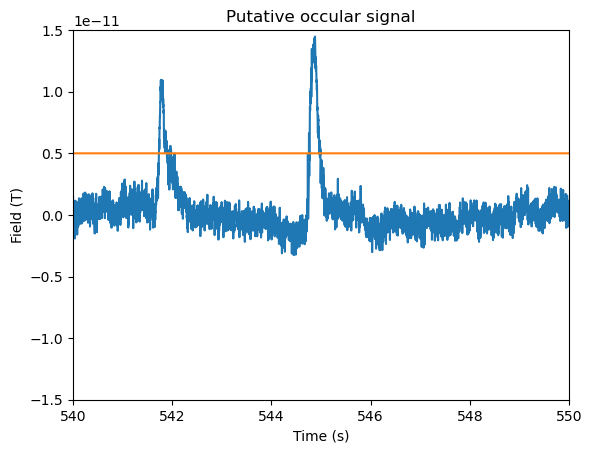

In [6]:
tr = np.full(len(occ_signal), 0.5e-11)
plt.plot(raw.times,occ_signal,raw.times,tr)
plt.xlim(540,550);plt.ylim(-1.5e-11,1.5e-11);plt.xlabel('Time (s)');plt.ylabel('Field (T)');plt.title('Putative occular signal')

Two eye-blinks are clearly visible. The orange line denotes the threshold which is set to 0.5e-11.

Subsequently use the MNE-defined function to identify the ocular events:

In [7]:
eog_events = mne.preprocessing.find_eog_events(raw, ch_name='Trigger 2',thresh=0.5e-11) 

Using EOG channel: Trigger 2
EOG channel index for this subject is: [1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Trigger 2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 7500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 514 significant peaks
Number of EOG events detected: 514


In total, 514 events were identified as blinks. To write these events on the dataset, the next step is to create an annotation object which contains the onset of each blink, their durations (-0.25 s to 0.25 s) and a description label (i.e., tag) of the type of event:

In [8]:
n_blinks = len(eog_events)
onset = eog_events[:, 0] / raw.info['sfreq'] - 0.25
duration = np.repeat(0.5, n_blinks)
description = ['blink'] * n_blinks
orig_time = raw.info['meas_date']
annotations_blink = mne.Annotations(onset, duration, description, orig_time)


## Detecting muscle artefacts

Muscle artefacts are identified from the magnetometer data filtered in the 105 - 130 Hz range. The data are subsequently z-scored. If they exceed a z-score of 4, the corresponding section of data is annotated as a muscle artefact. The shortest allowed duration of non-annotated data is 0.2 s; shorter segments will be incorporated into the surrounding annotations.


Before computing the Z-score make sure the 'bad' channels are removed.

In [9]:
raw_clean = raw.copy().drop_channels(raw.info['bads'])

At ARNAB: do we want to remove bad channels for good?

Compute the Z-score

In [10]:
threshold_muscle = 2.5
annotations_muscle, scores_muscle = annotate_muscle_zscore(
    raw_clean, ch_type="mag", threshold=threshold_muscle, min_length_good=0.1,
    filter_freq=[105, 130])


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 1.3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 105.00
- Lower transition bandwidth: 26.25 Hz (-6 dB cutoff frequency: 91.88 Hz)
- Upper passband edge: 130.00 Hz
- Upper transition bandwidth: 32.50 Hz (-6 dB cutoff frequency: 146.25 Hz)
- Filter length: 95 samples (0.127 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    7.1s


Setting up low-pass filter at 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1239 samples (1.652 s)



Muscle artefacts identified:

In [13]:
print(annotations_muscle)

<Annotations | 59 segments: BAD_muscle (59)>


To check whether the threshold used for the muscle annotation is appropriate, plot the z-scores as a funnction of time. The threshold is indicated by a red line.

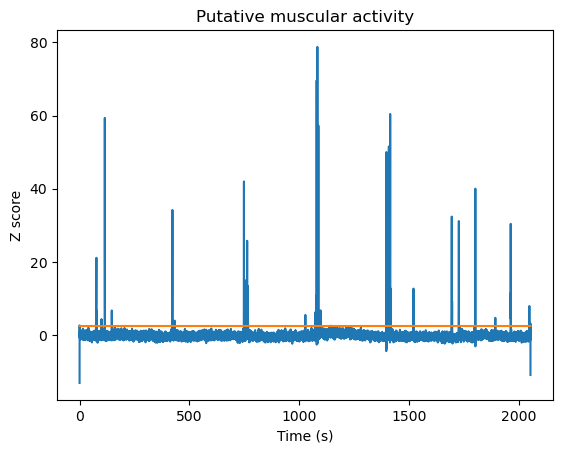

In [14]:
tr = np.full(len(scores_muscle), 2.5)
plt.plot(raw_clean.times, scores_muscle,raw_clean.times, tr);
plt.xlabel('Time (s)');plt.ylabel('Z score');plt.title('Putative muscular activity');

## Include annotations in dataset and inspect visually

Now mark all the annotations in the data set.

Since calling set_annotations() replaces any existing annotations in the Raw object, the original annotations are first extracted and then combined with the blink and muscle annotations before being reassigned.

In [15]:
annotations_event = raw.annotations 
raw_clean.set_annotations(annotations_event + annotations_blink + annotations_muscle)

/var/folders/n0/w7vb4jpn0nx3hs95f4p7r9br0000gr/T/ipykernel_41782/2036331298.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_clean.set_annotations(annotations_event + annotations_blink + annotations_muscle)


<Raw | sub-01_ses-01_task-SpAtt_run-01_hfc_raw.fif, 207 x 1539808 (2053.1 s), ~2.38 GiB, data loaded>

To inspect the annotations visually write

In [16]:
%matplotlib inline
raw_clean.plot(start=50)

Using qt as 2D backend.
Using pyopengl with version 3.1.6


<mne_qt_browser._pg_figure.MNEQtBrowser(0x3472efa00) at 0x347ddfa80>

Waiting for Loading-Thread to finish... (max. 10 sec)


/Users/o.jensen@bham.ac.uk/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


Channels marked as bad:
none


To specifically inspect the ocular artefacts display the ocular signed assigned before (use the + button to increase the signal id not visible):

In [17]:
raw_clean.set_channel_types({'Trigger 2':'eog'})
eog_picks=mne.pick_types(raw_clean.info,meg=False,eog=True)
raw_clean.plot(order=eog_picks,start=50)

Using pyopengl with version 3.1.6


<mne_qt_browser._pg_figure.MNEQtBrowser(0x3588f4790) at 0x359ff1800>

### Save the artefact annotations

Save the annotations in a file to be used in the subsequent sections:

In [18]:
raw_clean.save(deriv_fname_fif, overwrite=True)
raw_clean.annotations.save(deriv_fname_csv, overwrite=True)

Overwriting existing file.
Writing /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif
Closing /Users/o.jensen@bham.ac.uk/Library/CloudStorage/Dropbox/FLUX/OPM-Oxf/fif/Cerca_Spatt_BIDS/derivatives/preprocessing/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-01_ann_raw.fif
[done]
Overwriting existing file.
Channels marked as bad:
none


/Users/o.jensen@bham.ac.uk/Applications/MNE-Python/1.9.0_0/.mne-python/lib/python3.12/site-packages/mne_qt_browser/_pg_figure.py:3061: RuntimeWarning: Failed to disconnect (None) from signal "triggered()".
  sig.disconnect()


## References

[1] Muthukumaraswamy, S. (2013). *High-frequency brain activity and muscle artifacts in MEG/EEG: a review and recommendations*. *Frontiers in Human Neuroscience*, **7**, 138. [https://doi.org/10.3389/fnhum.2013.00138](https://doi.org/10.3389/fnhum.2013.00138)

[2] Hu, Y., Yin, C., Zhang, J., & Wang, Y. (2018). *Partial Least Square Aided Beamforming Algorithm in Magnetoencephalography Source Imaging*. *Frontiers in Neuroscience*, **12**, 616. [https://doi.org/10.3389/fnins.2018.00616](https://doi.org/10.3389/fnins.2018.00616)
